In [0]:
!pip install tensorflow==1.12

In [1]:
#!pip install tf-nightly
#!apt-get install -qq protobuf-compiler python-tk
#!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install matplotlib PyDrive
!pip install -q pycocotools

    100% |████████████████████████████████| 993kB 9.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)
  
sess = tf.Session(config=config)

try:
  sess.run(tf.global_variables_initializer())
  print('ok')
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
ok


In [2]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

PROJ = "My Drive/panda" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

%cd ~/content
%cd drive/My Drive/panda

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
[Errno 2] No such file or directory: '/root/content'
/content
/content/drive/My Drive/panda


In [5]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 25233 (delta 47), reused 43 (delta 16), pack-reused 25139
Receiving objects: 100% (25233/25233), 507.70 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (15054/15054), done.
Checking out files: 100% (2868/2868), done.


In [12]:
fileId = '1wbrjkjKZJsEfFRk6dEzkaBAWdZ7KZtIp'


import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
#os.remove(fileName)
print('Extracted zip file ' + fileName)

Extracted zip file 1wbrjkjKZJsEfFRk6dEzkaBAWdZ7KZtIp.zip


In [13]:
%cd annotations

!mkdir trimaps

import os
from PIL import Image
image = Image.new('RGB', (300, 300))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/content/drive/My Drive/panda/annotations


In [5]:
%cd ~
%cd /content
%cd drive/My Drive/panda/models/research
!pwd
!protoc object_detection/protos/*.proto --python_out=.

/root
/content
/content/drive/My Drive/panda/models/research
/content/drive/My Drive/panda/models/research


In [4]:
%cd ~
%cd /content
%cd drive/My Drive/panda/
import os
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/panda/models/research/:/content/drive/My Drive/panda/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/panda/models/research/:/content/drive/My Drive/panda/models/research/object_detection/'
!python models/research/object_detection/builders/model_builder_test.py

/root
/content
/content/drive/My Drive/panda

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.060s

OK (skipped=1)


In [15]:
!python create_tf_record.py \
    --data_dir=!pwd \
    --output_dir=!pwd

/content/drive/My Drive/panda/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [0]:
import os
import shutil
import glob
import urllib
import tarfile
import urllib.request


MODEL = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

!mkdir "pretrained_model"

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.request.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [0]:
import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '/content/drive/My Drive/panda/pretrained_model/pipeline.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/drive/My Drive/panda/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record', '/content/drive/My Drive/panda/train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record', '/content/drive/My Drive/panda/val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/drive/My Drive/panda/annotations/label_map.pbtxt', s)
  f.write(s)

In [0]:
import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '/content/drive/My Drive/panda/pretrained_model/pipeline.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/drive/My Drive/panda/fine_tuned_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record', '/content/drive/My Drive/panda/train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record', '/content/drive/My Drive/panda/val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/drive/My Drive/panda/annotations/label_map.pbtxt', s)
  f.write(s)

In [10]:
%cd ~
%cd /content
%cd drive/My Drive/panda/
!python models/research/object_detection/model_main.py \
    --pipeline_config_path="/content/drive/My Drive/panda/pretrained_model/pipeline.config" \
    --model_dir="/content/drive/My Drive/panda/trained" \
    --alsologtostderr \
    --num_train_steps=40000

/root
/content
/content/drive/My Drive/panda

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-04-19 03:28:07.750752: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-19 03:28:07.751019: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x12dc8b00 executing compu

In [5]:
import os
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path="/content/drive/My Drive/panda/pretrained_model/pipeline.config" \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
378 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-a

/root
/content
/content/drive/My Drive/panda/models/research/object_detection


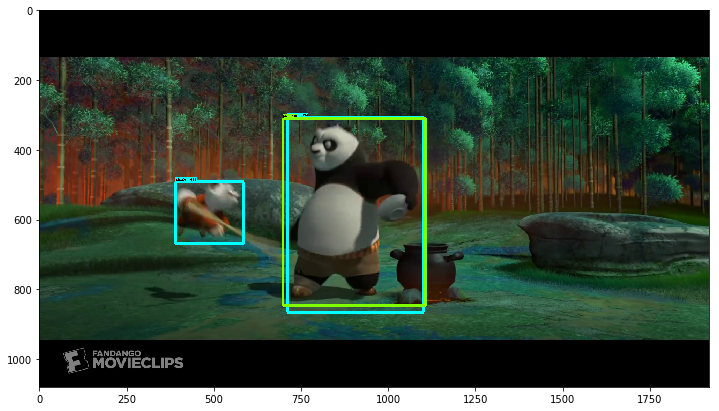

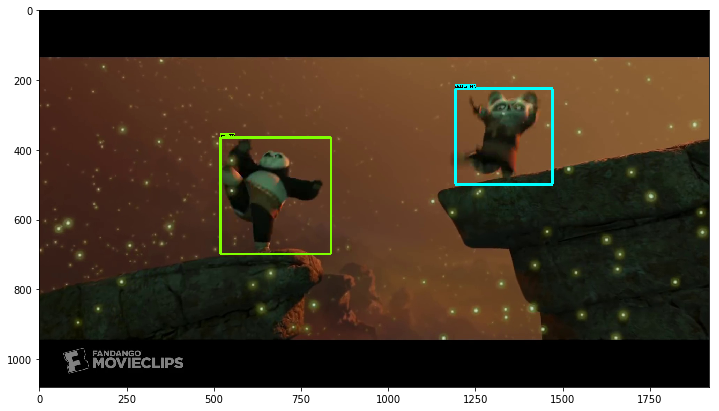

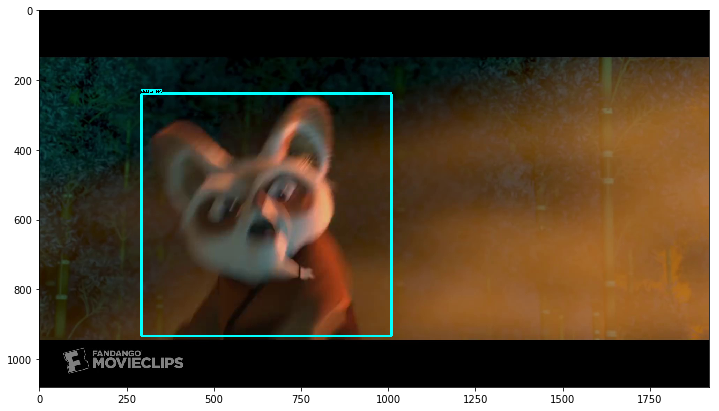

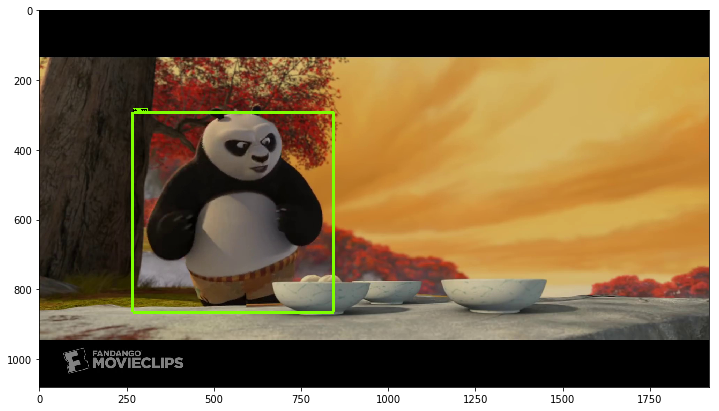

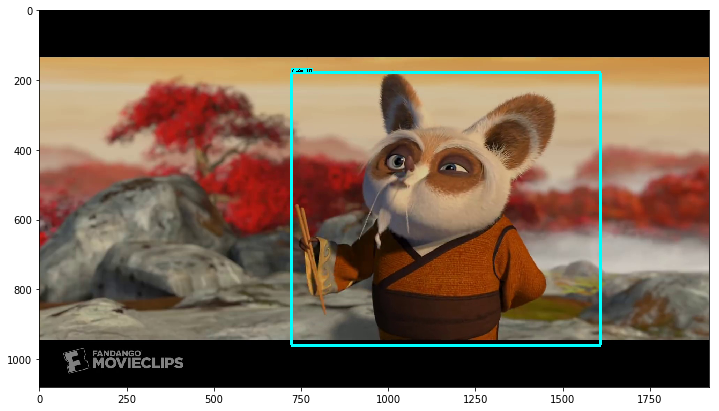

In [9]:
%cd ~
%cd /content
%cd drive/My Drive/panda/models/research/object_detection/

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/drive/My Drive/panda/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/drive/My Drive/panda/annotations', 'label_map.pbtxt')

NUM_CLASSES = 2




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/drive/My Drive/panda/Test/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)